Yiwei Chen (yc3289)

Daming Liu （dl4430)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls /content/drive/MyDrive/cv_project

annotation1.csv     Lana		scene2-camera3.avi  scene4-camera2.avi
annotation2.csv     Liz			scene3-camera1.avi  scene4-camera3.avi
asl_2008_01_11_avi  naomi		scene3-camera2.avi  tmp
asl_2008_01_18_avi  scene2-camera1.avi	scene3-camera3.avi  Tyler
Dana		    scene2-camera2.avi	scene4-camera1.avi


In [3]:
!pip install -U opencv-python
!pip install mediapipe

In [4]:
import numpy as np
import cv2
import csv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import mediapipe as mp
import collections

import math
from os import walk
import torch
from torch import linalg as LA
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py
import seaborn as sns


In [5]:
import torch
import math
from torch import linalg as LA
from numpy import linalg as npLA

def get_center_dist(root_pos, i, j):
    v1 = root_pos[i:j]
    # print(v1.size())

    center = torch.sum(v1, 0) / (j - i)
    v2 = center.repeat(j - i).view(j - i, -1)
    # print(v2.size())

    v3 = v1 - v2
    v4 = LA.vector_norm(v3, dim = 1)
    dist_sum = torch.sum(v4)

    return dist_sum, center

def focus(root_pos, window_duration, fps):
    # root_pos shape: n_frame * 21 * 3
    window_frame_n = int(window_duration * fps)
    n = root_pos.shape[0]
    # print(n, window_frame_n)

    if window_frame_n > n:
        window_frame_n = n

    min_dist_sum = math.inf
    center = torch.zeros(3)
    segment_start = -1

    for i in range(0, n - window_frame_n + 1):
        tmp_sum, tmp_center = get_center_dist(root_pos, i, i + window_frame_n)
        if (tmp_sum < min_dist_sum):
            min_dist_sum = tmp_sum
            center = tmp_center
            segment_start = i

    assert segment_start != -1

    # print(segment_start)
    return center, segment_start, segment_start + window_frame_n

# =======================================================================test1
# root_pos = torch.randn(100, 3)
# center = calc_root_pos_center(root_pos, window_duration, fps)
# print(center)

# ========================================================================test2
# r1 = torch.randn((30,3)) * 3
# a = torch.tensor([1,1,1]).repeat(20).view(20, -1)
# r2 = torch.randn((30,3)) * 5
# b = torch.cat((r1, a, r2), 0)
# center = calc_root_pos_center(b, window_duration, fps)
# print(center)

# v1 = torch.tensor([[3,3,3],[4,4,4],[2,2,2]])
# print(get_center_dist(v1, 0, 3))

# v2 = torch.tensor([[1,1,1],[1,1,1],[1,1,1]])
# print(get_center_dist(v2, 0, 3))

# frames = 100
# sample_np = np.random.rand(frames, 21, 3)
# one_sample_data = torch.from_numpy(sample_np)

def stretch(input, new_len):

    # input:  n_frame_old * n_feature * 3
    # new_len : stretch to new_len

    # print(input.shape)
    old_len = input.shape[0]
    # print("old_len= ", old_len)
    output = torch.zeros((new_len, input.shape[1], 3))
    
    for i in range(new_len):
        # print()
        p = i / (new_len - 1)
        # print("p= ", p)
        pos = int( (old_len - 1) * p)
        print("pos= ", pos)
        w2 = (old_len - 1) * p - pos
        # print("w2 = ", w2)
        w1 = 1 - w2
        v = w1 * input[pos]
        if pos + 1 < old_len:
            v += w2 * input[pos + 1]
        # print(v.shape)
        output[i] = v

    return output


def focus_and_stretch(input, n_frame_output = 100, window_duration = 1.0, fps = 20, b_numpy = True):

    # input shape : 2 * n_frame * 21 * 3
    # output shape: 2 * n_frame_output * 21 * 3

    if b_numpy:
        input = torch.from_numpy(input)

    c1_center, c1_start, c1_end = focus(input[0,:,0,:], window_duration, fps)
    c2_center, c2_start, c2_end = focus(input[1,:,0,:], window_duration, fps)

    # print(c1_center, c1_start, c1_end)
    # print(c2_center, c2_start, c2_end)

    c1_input = input[0, c1_start:c1_end, :, :]
    c2_input = input[1, c2_start:c2_end, :, :]

    c1_input = c1_input[:,:,:] - c1_center
    c2_input = c2_input[:,:,:] - c2_center

    # convert to relative coordinate
    c1_output = stretch(c1_input, n_frame_output)
    c2_output = stretch(c2_input, n_frame_output)

    # output = torch.cat((c1_output, c2_output))
    output = torch.stack([c1_output, c2_output])

    if b_numpy:
        output = output.numpy()

    return output

# # === test focus_and_stretch ===
# test_data = torch.ones((2, 10, 21, 3))
# test_output = focus_and_stretch(test_data, 20, 1, 5, False)
# # print(test_data)
# # print(test_output)
# print(test_output.shape)

# # === test focus_and_stretch ===
# test_data = np.random.rand(2, 10, 21, 3)
# test_output = focus_and_stretch(test_data, 40, 1, 20, True)
# print(type(test_output))
# print(test_output.shape)

# # === test stretch ===
# test_data = torch.zeros((5, 21, 3))
# # test_data[2,:,:] = torch.ones((21, 3)) * 10
# test_data[2,0,:] = torch.ones(3) * 10
# test_output = stretch(test_data, 21)
# # for i in range(test_output.shape[0]):
# #     print(test_output[i])

def pre_precess_2(input, n_frame_output = 50, b_numpy = True, b_stretch = False):

    # input shape : 2 * n_frame * 21 * 3
    # output shape: 2 * n_frame_output * 21 * 3

    # if b_numpy:
    #     input = torch.from_numpy(input)

    output = np.copy(input)

    # print(output.shape)

    n_current_frame = output.shape[1]

    # root diff
    root0 = output[0, :, 0, :]
    root1 = output[1, :, 0, :]

    root_diff_0_1 = root1 - root0
    root_diff_1_0 = root0 - root1
    root_diff_2 = np.stack([root_diff_0_1, root_diff_1_0])
    root_diff_2 = np.expand_dims(root_diff_2, axis=2)

    # root distance
    root_dist = npLA.norm(root_diff_0_1, axis=1)
    root_dist = np.stack([root_dist, root_dist, root_dist])
    # print(root_dist.shape)
    root_dist = np.swapaxes(root_dist, 0, 1)
    root_dist_2 = np.stack([root_dist, root_dist])
    root_dist_2 = np.expand_dims(root_dist_2, axis=2)

    # centroid pos
    centroid = np.sum(output, axis = 2) / output.shape[2]
    centroid_2 = np.expand_dims(centroid, axis=2)


    # centroid speed
    centroid_speed = np.zeros((2, n_current_frame, 3))
    for i in range(1, n_current_frame):
        centroid_speed[:, i] = centroid[:,i] - centroid[:, i - 1]
    centroid_speed_2 = np.expand_dims(centroid_speed, axis=2)

    # finger tip dist
    finger_dist = np.zeros((2, n_current_frame, 3))
    for i in range(output.shape[0]): # hand
        for j in range(output.shape[1]): # frame
            f_dist_1 = npLA.norm(output[i,j,4] - output[i,j,8])
            f_dist_2 = npLA.norm(output[i,j,8] - output[i,j,12])
            f_dist_3 = npLA.norm(output[i,j,12] - output[i,j,16])
            f_dist_4 = npLA.norm(output[i,j,16] - output[i,j,20])
            f_dist = f_dist_1 + f_dist_2 + f_dist_3 + f_dist_4
            finger_dist[i,j,0] = f_dist
            finger_dist[i,j,1] = f_dist
            finger_dist[i,j,2] = f_dist
    finger_dist_2 = np.expand_dims(finger_dist, axis=2)

    # change to relative
    for i in range(output.shape[0]): # hand
        for j in range(output.shape[1]): # frame
            for k in range(output.shape[2]-1, -1, -1): # landmark
                output[i,j,k] = output[i,j,k] - output[i,j,0]


    output = np.concatenate((root_diff_2, output), axis=2)
    output = np.concatenate((root_dist_2, output), axis=2)
    output = np.concatenate((centroid_2, output), axis=2)
    output = np.concatenate((centroid_speed_2, output), axis=2)
    output = np.concatenate((finger_dist_2, output), axis=2)

    # print(output.shape)

    if b_stretch:
        # === stretch to n_frame_output
        c1_input = torch.from_numpy(output[0, :, :, :])
        c2_input = torch.from_numpy(output[1, :, :, :])

        # print("c1_input: ", c1_input)

        c1_output = stretch(c1_input, n_frame_output)
        c2_output = stretch(c2_input, n_frame_output)

        # print("c1_output: ", c1_output)

        c1_output = c1_output.numpy()
        c2_output = c2_output.numpy()
        output = np.stack([c1_output, c2_output])
        # === end of stretch
    else:
        output.resize((2,n_frame_output,output.shape[2],3))
        # if output.shape[1] < n_frame_output:
        #     last_frame = output[:, output.shape[1]-1,:,:]
        #     last_frame_arr = [last_frame] * (n_frame_output - output.shape[1])
        #     last_frame_repeat = np.stack(last_frame_arr)
        #     print(last_frame_repeat.shape)
        #     output = np.concatenate((output, last_frame_repeat), axis=1)
        # else:
        #     output = output.resize(2,n_frame_output,output.shape[2],3)

    # if b_numpy:
    #     output = output.numpy()

    return output

# np.set_printoptions(precision=2)
# test_input = np.random.rand(2, 5, 21, 3)
# test_input = np.zeros((2, 20, 21, 3))
# test_input[:,2,1:,:] = np.ones((2,4,3)) * 10
# test_input[0,:,:,:] = np.ones((3,5,3)) * 10
# test_input[0,1,:,:] = np.ones((5,3)) * 8
# print(test_input)
# test_output = pre_precess_2(test_input, n_frame_output=60, b_stretch=False)
# print(test_output)



In [6]:
def parse(filepath):
  annotation = collections.defaultdict(str)
  with open(filepath, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      
      sessionAndScene = row['MOV']
      label = row['Sign gloss']
      startFrame = int(row['Gloss start'])
      endFrame = int(row['Gloss end'])
      totalFrames = endFrame-startFrame
      
      for frame in range(startFrame, endFrame+1):
        position = float(frame - startFrame)/totalFrames
        annotation[(sessionAndScene, frame)] = label
  return annotation

'''
filepath1 = '/content/drive/MyDrive/cv_project/annotation1.csv'
filepath2 = '/content/drive/MyDrive/cv_project/annotation2.csv'

annotation1 = parse(filepath1)
annotation2 = parse(filepath2)

#for session, frame in annotation1:
  #print (f"{session}, {frame}: {annotation1[(session,frame)]}")
'''

'\nfilepath1 = \'/content/drive/MyDrive/cv_project/annotation1.csv\'\nfilepath2 = \'/content/drive/MyDrive/cv_project/annotation2.csv\'\n\nannotation1 = parse(filepath1)\nannotation2 = parse(filepath2)\n\n#for session, frame in annotation1:\n  #print (f"{session}, {frame}: {annotation1[(session,frame)]}")\n'

In [7]:
data = collections.defaultdict(list)
testData = collections.defaultdict(list)

labels = collections.defaultdict(str)
ID = 0 # global ID
labelsIndex = []

def readVideo(filepath, annotation, test=False):
  global ID, data, labels

  datasetLeft = collections.defaultdict(list)
  datasetRight = collections.defaultdict(list)

  videoName = (filepath.split('/')[-1]).split('.')[0] 
  if videoName[-1] != '1':
    return
  
  print(f"Video Name is {videoName}")
  
  # Initalize hands
  mpHands = mp.solutions.hands
  hands = mpHands.Hands()
  mpDraw = mp.solutions.drawing_utils

  vid = cv2.VideoCapture(filepath)
  frames_total = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
  print (f"Total frames: {frames_total}")
  for frame in range(frames_total):      
      ret, img = vid.read()
      try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      except:
        continue
      label = annotation[(videoName, frame)]
      if label: 
        results = hands.process(img)
        if results.multi_hand_landmarks:

          # left hand = 0; right hand = 1
          hand = 0

          for handLms in results.multi_hand_landmarks:
            handLandMarks = []
            for id, lm in enumerate(handLms.landmark):
              if id == 0:
                x,y,z = lm.x, lm.y, lm.z
            #   handLandMarks.append([lm.x-x, lm.y-y, lm.z-z]) # Normalize 
              handLandMarks.append([lm.x, lm.y, lm.z]) # no Normalize 
            
            if hand == 0:
              datasetLeft[label].append(np.array(handLandMarks))
            elif hand == 1:
              datasetRight[label].append(np.array(handLandMarks))
            hand += 1

          if hand == 1:
            datasetRight[label].append(np.zeros((21, 3)))
            

  #print(datasetRight.values())
  # Release resources and Destroy all the windows
  vid.release() 
  cv2.destroyAllWindows() 

  for label in list(datasetLeft.keys()):
    # data[ID] = np.resize(np.array([datasetLeft[label], datasetRight[label]]),(2, 60, 21, 3))
    if not test:
      data[ID] = np.array([datasetLeft[label], datasetRight[label]])
    else:
      testData[ID] = np.array([datasetLeft[label], datasetRight[label]])
    labels[ID] = label
    ID += 1
#readVideo('/content/drive/MyDrive/cv_project/asl_2008_01_11_avi/scene2-camera1.mov.avi', annotation1)


In [8]:
dirs = ['Dana/', 'Liz/', 'Tyler/', 'naomi/']
prefix = '/content/drive/MyDrive/cv_project/'
for dir in dirs:
  print (dir)
  dir = prefix + dir
  for (dirpath, dirnames, filenames) in walk(dir):
    for filename in filenames:
      annotation = parse(dir + 'annotation.csv')
      if filename.split('.')[-1] == 'avi':
        readVideo(dir+filename, annotation) 

# load testing data
dirs = ['Lana/']
for dir in dirs:
  print (dir)
  dir = prefix + dir
  for (dirpath, dirnames, filenames) in walk(dir):
    for filename in filenames:
      annotation = parse(dir + 'annotation.csv')
      if filename.split('.')[-1] == 'avi':
        readVideo(dir+filename, annotation, True) # testing

Dana/
Video Name is scene6-camera1
Total frames: 3536
Video Name is scene7-camera1
Total frames: 3400
Liz/
Video Name is scene1-camera1
Total frames: 2036
Video Name is scene10-camera1
Total frames: 3368
Video Name is scene2-camera1
Total frames: 3604
Video Name is scene3-camera1
Total frames: 3604
Video Name is scene4-camera1
Total frames: 3604
Video Name is scene5-camera1
Total frames: 2460
Video Name is scene6-camera1
Total frames: 3536
Video Name is scene7-camera1
Total frames: 3400
Video Name is scene8-camera1
Total frames: 3276
Video Name is scene9-camera1
Total frames: 3256
Video Name is scene11-camera1
Total frames: 1644
Video Name is scene12-camera1
Total frames: 1768
Video Name is scene13-camera1
Total frames: 1924
Video Name is scene14-camera1
Total frames: 1664
Video Name is scene15-camera1
Total frames: 1704
Video Name is scene16-camera1
Total frames: 932
Video Name is scene17-camera1
Total frames: 364
Video Name is scene18-camera1
Total frames: 2136
Video Name is scene19-

In [9]:
print(f"Number of labels: {len(set(labels.values()))}")
print(f"length of data: {len(data)}")
labelsIndex = list(set(labels.values()))
print(len(labelsIndex))

Number of labels: 162
length of data: 469
162


In [10]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels, data):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.data = data

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = (self.data[ID]).astype(np.float32)
        y = float(labelsIndex.index(self.labels[ID]))

        return X, y



In [11]:
import random
batch_size = 8

# Random shuffle test data and train data
l = list(data.items())

for i in range(len(l)):
    l[i] = l[i][0], pre_precess_2(l[i][1])

random.shuffle(l)

l_train = dict(l)
l = list(testData.items())

for i in range(len(l)):
    l[i] = l[i][0], pre_precess_2(l[i][1])
    
random.shuffle(l)

l_test = dict(l)

print(len(l_train), len(l_test))

trainDataset = Dataset(list(l_train.keys()), labels, l_train)
train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)

testDataset = Dataset(list(l_test.keys()), labels, l_test)
test_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)

469 19


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net3d(nn.Module):
    
    # Contructor
    def __init__(self):
        super(Net3d, self).__init__()

        self.conv_layer1 = self._conv_layer_set(2, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(14336, 512)
        self.fc2 = nn.Linear(512, len(labelsIndex))
        self.relu = nn.LeakyReLU()
        self.batch1=nn.BatchNorm1d(512)

        self.batch3d_1=nn.BatchNorm3d(128)
        self.batch3d_2=nn.BatchNorm3d(128)
        self.drop=nn.Dropout(p=0.15)   
    
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(3, 3, 3), padding=2),
        nn.BatchNorm3d(out_c),
        nn.LeakyReLU(),
        nn.MaxPool3d((2, 2, 2)),
        nn.Dropout(p=0.15),
        )
        return conv_layer

    # Prediction
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.batch1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out



In [31]:
network = Net3d()
optimizer = optim.SGD(network.parameters(), lr=0.01)

In [32]:
batch_idx, (data, target) = next(enumerate(train_loader))
data = Variable(data)
output = network(data)

In [33]:
train_loss_arr = []
test_loss_arr = []
accuracy_arr = []

In [34]:
def train(epoch, network):
    network.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = Variable(data)

        target = Variable(target)

        optimizer.zero_grad()
        output = network(data)
        #print(output.size(), target.size())
        error = nn.CrossEntropyLoss()

        loss = error(output, target.type(torch.LongTensor))
        train_loss += loss
        
        loss.backward()
        # Update parameters
        optimizer.step()


        
        #loss = F.cross_entropy(output, target)
        #loss.backward()
        #optimizer.step()
        if batch_idx % 32 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    train_loss /= len(train_loader.dataset)
    train_loss_arr.append(train_loss)



In [35]:
def test_top_10_per(network):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)

        error = nn.CrossEntropyLoss()
        loss = error(output, target.type(torch.LongTensor))
        test_loss += loss

        k = int(0.1 * len(labelsIndex))
        topk_indices = output.data.topk(k)[1]
        for i in range(topk_indices.shape[0]):
            for j in range(topk_indices.shape[1]):
                if topk_indices[i,j] == target[i]:
                    correct += 1
                    continue
            
        # pred = output.data.max(5, keepdim=True)[1] # get the index of the max log-probability
        # print(pred)
        # correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    print(f'\n Test set: Top 10% Accuracy: {correct}/{len(test_loader.dataset)} ({correct / len(test_loader.dataset)}%)\n')
    
    test_loss /= len(test_loader.dataset)
    test_loss_arr.append(test_loss)
    accuracy_arr.append(correct / len(test_loader.dataset))

In [36]:
for epoch in range(1, 60 + 1):
    train(epoch, network)
    test_top_10_per(network)

Train Epoch: 1 [0/469 (0%)]	Loss: 5.258418
Train Epoch: 1 [256/469 (54%)]	Loss: 5.513634

 Test set: Top 10% Accuracy: 5/19 (0.2631578947368421%)

Train Epoch: 2 [0/469 (0%)]	Loss: 4.891060
Train Epoch: 2 [256/469 (54%)]	Loss: 4.694364

 Test set: Top 10% Accuracy: 11/19 (0.5789473684210527%)

Train Epoch: 3 [0/469 (0%)]	Loss: 4.238904
Train Epoch: 3 [256/469 (54%)]	Loss: 4.002655

 Test set: Top 10% Accuracy: 11/19 (0.5789473684210527%)

Train Epoch: 4 [0/469 (0%)]	Loss: 3.751606
Train Epoch: 4 [256/469 (54%)]	Loss: 4.261286

 Test set: Top 10% Accuracy: 10/19 (0.5263157894736842%)

Train Epoch: 5 [0/469 (0%)]	Loss: 3.723003
Train Epoch: 5 [256/469 (54%)]	Loss: 3.623723

 Test set: Top 10% Accuracy: 11/19 (0.5789473684210527%)

Train Epoch: 6 [0/469 (0%)]	Loss: 3.379112
Train Epoch: 6 [256/469 (54%)]	Loss: 3.616726

 Test set: Top 10% Accuracy: 10/19 (0.5263157894736842%)

Train Epoch: 7 [0/469 (0%)]	Loss: 3.364928
Train Epoch: 7 [256/469 (54%)]	Loss: 3.362605

 Test set: Top 10% Accu

In [37]:
print(train_loss_arr)
print(test_loss_arr)
print(accuracy_arr)

[tensor(0.6563, grad_fn=<DivBackward0>), tensor(0.5976, grad_fn=<DivBackward0>), tensor(0.5590, grad_fn=<DivBackward0>), tensor(0.5191, grad_fn=<DivBackward0>), tensor(0.4844, grad_fn=<DivBackward0>), tensor(0.4482, grad_fn=<DivBackward0>), tensor(0.4145, grad_fn=<DivBackward0>), tensor(0.3830, grad_fn=<DivBackward0>), tensor(0.3497, grad_fn=<DivBackward0>), tensor(0.3223, grad_fn=<DivBackward0>), tensor(0.2946, grad_fn=<DivBackward0>), tensor(0.2695, grad_fn=<DivBackward0>), tensor(0.2428, grad_fn=<DivBackward0>), tensor(0.2227, grad_fn=<DivBackward0>), tensor(0.2037, grad_fn=<DivBackward0>), tensor(0.1843, grad_fn=<DivBackward0>), tensor(0.1645, grad_fn=<DivBackward0>), tensor(0.1472, grad_fn=<DivBackward0>), tensor(0.1321, grad_fn=<DivBackward0>), tensor(0.1221, grad_fn=<DivBackward0>), tensor(0.1052, grad_fn=<DivBackward0>), tensor(0.0991, grad_fn=<DivBackward0>), tensor(0.0845, grad_fn=<DivBackward0>), tensor(0.0770, grad_fn=<DivBackward0>), tensor(0.0714, grad_fn=<DivBackward0>),

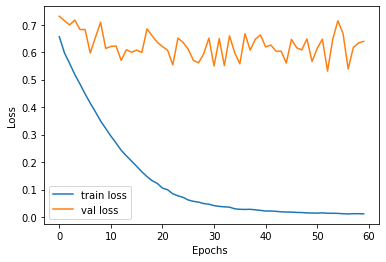

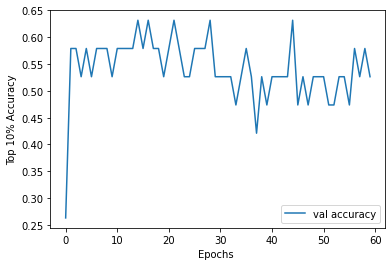

In [38]:
train_loss_arr_2 = []
test_loss_arr_2 = []
for v in train_loss_arr:
    train_loss_arr_2.append(v.item())
for v in test_loss_arr:
    test_loss_arr_2.append(v.item())

plt.plot(train_loss_arr_2, label='train loss')
plt.plot(test_loss_arr_2, label='val loss')
plt.ylabel('Loss')
plt.xlabel('Epochs ')   
plt.legend()
plt.show()

plt.plot(accuracy_arr, label='val accuracy')
plt.ylabel('Top 10% Accuracy')
plt.xlabel('Epochs ')   
plt.legend()
plt.show()